### U-net with simple Resnet Blocks
#### update log
1. Correct the errors to in function iou_metric,  use "my_iou_metric" to moniter the training
2. Use image size 101 x 101, no resizing
3. Last layer dropout reduced by half
4. replace conv2D with 2 basic resnet blocks in each level of U-net
5.  Use faster rle_encode (> 10 times fater than RLenc ) from (https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss)
6. set  random_state= 1234 

Reference kernels:

https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

https://www.kaggle.com/tgibbons/u-net-without-resizing-images

https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss

The results seems not reproducible,  sometimes good (best around IOU0.79 ), sometimes  not as good!
Any suggestions to improve the results?

In [ ]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

In [ ]:
import sys
sys.path.append('../../LovaszSoftmax/tensorflow')
import lovasz_losses_tf as L_loss

### Reproducability setup:

In [ ]:
import random as rn

kSeed = 241075

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(kSeed)
rn.seed(kSeed)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(kSeed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

In [ ]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = '../../../../Kaggle_Data/Salt/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'



In [ ]:
# Loading of training/testing ids and depths

train_df = pd.read_csv(basicpath+"/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(basicpath+"/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

In [ ]:
train_df["images"] = [np.array(load_img(path_train_images+"{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [ ]:
train_df["masks"] = [np.array(load_img(path_train_masks+"{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [ ]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [ ]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [ ]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [ ]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


In [ ]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [ ]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [ ]:
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("metric = ",metric)
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value


In [ ]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(x_valid.shape)

In [ ]:
def lavazs_loss(labels, scores): # Keras and TF has reversed order of args
    return L_loss.lovasz_hinge(2*scores-1, labels, ignore=255, per_image=True)

In [ ]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", my_iou_metric])

In [ ]:
model.load_weights('./unet_best  18.09.04.23.20.model')

In [21]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=30, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=10, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 25

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
 - 52s - loss: 0.1239 - acc: 0.9538 - my_iou_metric: 0.8566 - val_loss: 0.1557 - val_acc: 0.9418 - val_my_iou_metric: 0.8414

Epoch 00001: val_my_iou_metric improved from -inf to 0.84138, saving model to ./unet_best1.model
Epoch 2/200
 - 40s - loss: 0.1178 - acc: 0.9560 - my_iou_metric: 0.8616 - val_loss: 0.1722 - val_acc: 0.9424 - val_my_iou_metric: 0.8456

Epoch 00002: val_my_iou_metric improved from 0.84138 to 0.84556, saving model to ./unet_best1.model
Epoch 3/200
 - 40s - loss: 0.1160 - acc: 0.9561 - my_iou_metric: 0.8609 - val_loss: 0.1418 - val_acc: 0.9497 - val_my_iou_metric: 0.8532

Epoch 00003: val_my_iou_metric improved from 0.84556 to 0.85316, saving model to ./unet_best1.model
Epoch 4/200
 - 40s - loss: 0.1192 - acc: 0.9551 - my_iou_metric: 0.8578 - val_loss: 0.1465 - val_acc: 0.9469 - val_my_iou_metric: 0.8502

Epoch 00004: val_my_iou_metric did not improve
Epoch 5/200
 - 40s - loss: 0.1127 - acc: 0.9574 - my_iou_


Epoch 00042: val_my_iou_metric did not improve
Epoch 43/200
 - 41s - loss: 0.0888 - acc: 0.9668 - my_iou_metric: 0.8825 - val_loss: 0.1397 - val_acc: 0.9512 - val_my_iou_metric: 0.8604

Epoch 00043: val_my_iou_metric did not improve
Epoch 44/200
 - 41s - loss: 0.0904 - acc: 0.9665 - my_iou_metric: 0.8814 - val_loss: 0.1662 - val_acc: 0.9468 - val_my_iou_metric: 0.8547

Epoch 00044: val_my_iou_metric did not improve
Epoch 45/200
 - 41s - loss: 0.0902 - acc: 0.9662 - my_iou_metric: 0.8816 - val_loss: 0.1469 - val_acc: 0.9486 - val_my_iou_metric: 0.8576

Epoch 00045: val_my_iou_metric did not improve

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 46/200
 - 41s - loss: 0.0750 - acc: 0.9723 - my_iou_metric: 0.8943 - val_loss: 0.1424 - val_acc: 0.9550 - val_my_iou_metric: 0.8719

Epoch 00046: val_my_iou_metric improved from 0.86797 to 0.87187, saving model to ./unet_best1.model
Epoch 47/200
 - 41s - loss: 0.0701 - acc: 0.9744 - my_iou_metric: 0.8992 

 - 40s - loss: 0.0550 - acc: 0.9794 - my_iou_metric: 0.9127 - val_loss: 0.1567 - val_acc: 0.9596 - val_my_iou_metric: 0.8832

Epoch 00084: val_my_iou_metric did not improve

Epoch 00084: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 85/200
 - 40s - loss: 0.0535 - acc: 0.9798 - my_iou_metric: 0.9131 - val_loss: 0.1476 - val_acc: 0.9610 - val_my_iou_metric: 0.8835

Epoch 00085: val_my_iou_metric did not improve
Epoch 86/200
 - 40s - loss: 0.0547 - acc: 0.9797 - my_iou_metric: 0.9135 - val_loss: 0.1406 - val_acc: 0.9613 - val_my_iou_metric: 0.8847

Epoch 00086: val_my_iou_metric did not improve
Epoch 87/200
 - 40s - loss: 0.0533 - acc: 0.9800 - my_iou_metric: 0.9141 - val_loss: 0.1382 - val_acc: 0.9620 - val_my_iou_metric: 0.8841

Epoch 00087: val_my_iou_metric did not improve
Epoch 88/200
 - 40s - loss: 0.0503 - acc: 0.9807 - my_iou_metric: 0.9152 - val_loss: 0.1497 - val_acc: 0.9607 - val_my_iou_metric: 0.8815

Epoch 00088: val_my_iou_metric did not improve
E

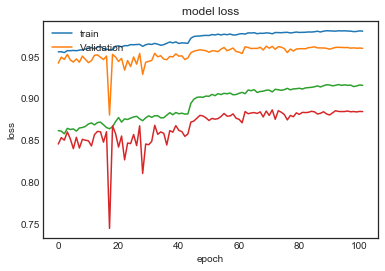

In [22]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()


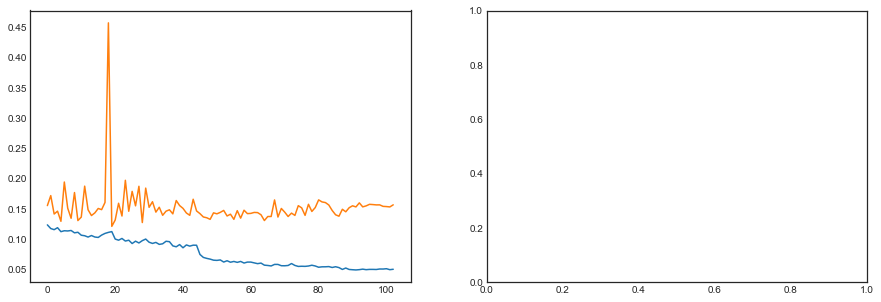

In [23]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

In [ ]:
model = load_model("./unet_best1.model",custom_objects={'my_iou_metric': my_iou_metric, 'lavazs_loss': lavazs_loss})

In [ ]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

In [ ]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [ ]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])


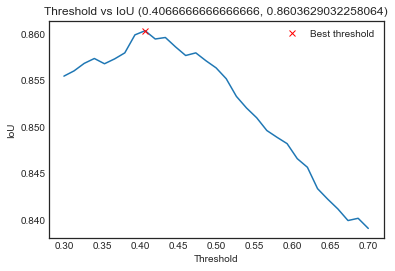

In [28]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
import gc

del x_train, x_valid, y_train, y_valid, preds_valid
gc.collect()

In [ ]:
x_test = np.array([(np.array(load_img(path_test_images+"{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

In [ ]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv.gz', compression = 'gzip')

In [ ]:
sub.head(10)